In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Fast gradient sign method(FGSM)

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:

$$
a d v_{-} x=x+\epsilon * \operatorname{sign}\left(\nabla_{x} J(\theta, x, y)\right)
$$

where
- adv_x: Adversarial image.
- $x:$ Original input image.
- y : Original input label.
- $\epsilon:$ Multiplier to ensure the perturbations are small.
- $\theta:$ Model parameters.
- $J:$ Loss.

An intriguing property here,is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is MobileNetV2 model, pretrained on ImageNet.

In [3]:
# Load tge pretrained MobileNetV2 model and the ImageNet weights
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [4]:
pretrained_model.trainable = False

In [5]:
# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [23]:
def preprocess(image):
    image = tf.image.resize(tf.cast(image, tf.float32), (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[tf.newaxis, ...]
    return image

In [13]:
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

## Original image

In [24]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

In [29]:
image = preprocess(image)
image_probs = pretrained_model.predict(image)

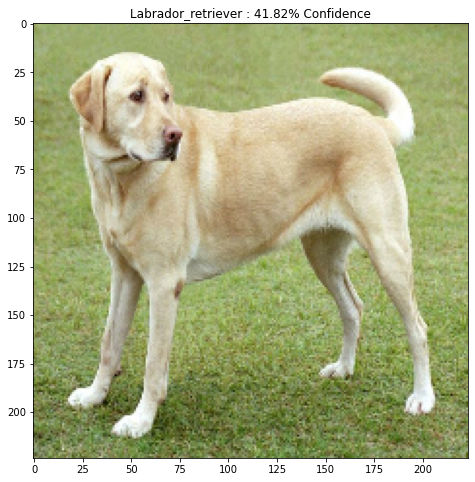

In [41]:
plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implement fast gradient sign method

In [42]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_patten(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

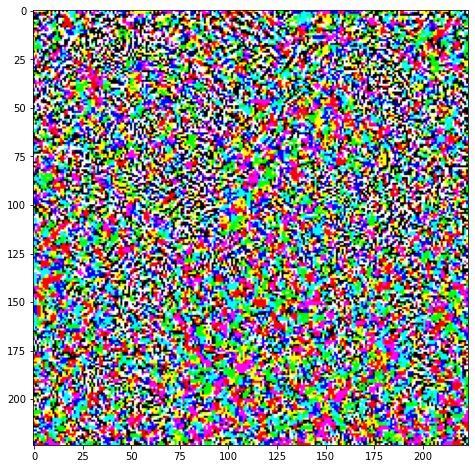

In [47]:
# The resulting perturbations can also be visualised.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_patten(image, label)
plt.imshow(perturbations[0]*0.5 + 0.5)

In [48]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                     label, confidence*100))
    plt.show()

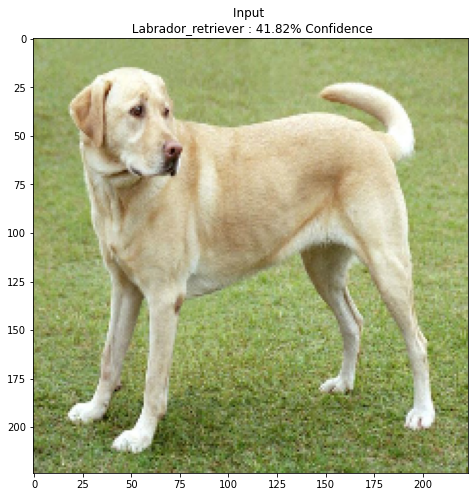

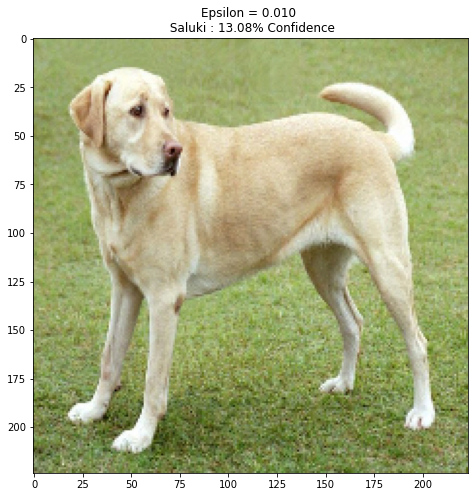

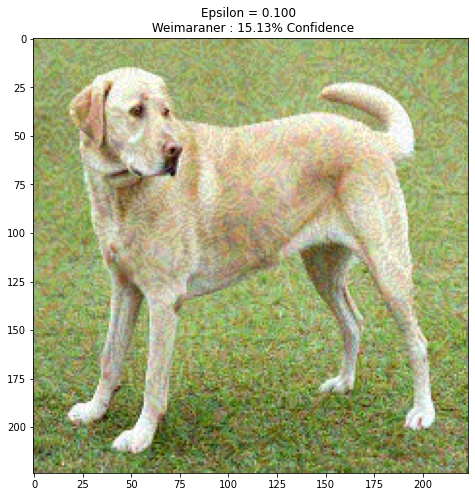

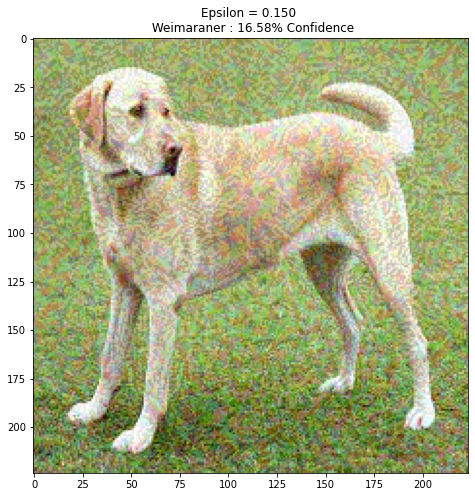

In [51]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])